<center><img src="../common/images/logo.png" alt="AWS Logo" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 1, Lab 2: Creating a Multilayer Perceptron and Using Dropout Layers

In this notebook, you will implement a simple neural network with multiple layers and analyze the training process. You will then implement dropout layers to prevent overfitting of the neural network.

**Multilayer perceptron**

The simplest feed-forward neural network architecture is a multilayer perceptron (MLP). An MLP is characterized by several layers of input neurons that are fully connected. Forming an MLP requires at least three layers: input layer, hidden layer, and output layer. An MLP uses backpropagation to train the network.

**Dropout layers**

To prevent overfitting of neural networks, it's possible to randomly drop a certain percentage of the neurons (or nodes) in the input and hidden layers. This has proven to be an effective technique for regularization and preventing the coadaptation of neurons (for neurons that show correlated behavior). The dropout layer only applies during training of the neural network. Neurons aren't dropped when making predictions (inference).

You will learn the following:

- How to define a single dense-layer neural network model
- How to train the neural network
- Why dropout layers are important
- How to add a dropout layer

---

You will be presented with activities throughout the notebook: <br/>

|<img style="float: center;" src="../common/images/activity.png" alt="Activity" width="125"/>| 
| --- | 
|<p style="text-align:center;"> No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p>|


---

## Index

* [Dataset](#Dataset)
* [Define the model](#Define-the-model)
* [Train the neural network](#Train-the-neural-network)
* [Add a dropout layer](#Add-a-dropout-layer)

---
## Dataset

The [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset consists of 28x28 (=784) pixel grayscale images from 10 categories. The dataset has 6,000 images in each category for the training dataset and 1,000 in each category for the test dataset. 

Your task is to build a classifier that maps the images to their categories. You will use PyTorch predefined layers and the default trainers for a swift and efficient implementation of an MLP.

In [1]:
# Install libraries
!pip install -U -q -r requirements.txt

In [3]:
# Import system library and append path
import sys
sys.path.insert(1, "..")

# Import utility functions that provide answers to challenges
from MLUDTI_EN_M1_Lab2_quiz_questions import *

# Import PyTorch library and plotting library
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt

# Load the image dataset with the torch helper functions

mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transforms.ToTensor(), download=True
)  # ToTensor converts the image data from PIL type to 32-bit floating point tensors.

mnist_val = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transforms.ToTensor(), download=True
)  # ToTensor converts the image data from PIL type to 32-bit floating point tensors.

# Pass batches of images to the neural network
batch_size = 256

# To load images in batches, you need the DataLoader helper function
training_loader = data.DataLoader(mnist_train, batch_size, shuffle=True)
validation_loader = data.DataLoader(mnist_val, batch_size, shuffle=False)

Look at some of the images to see what is in the dataset.

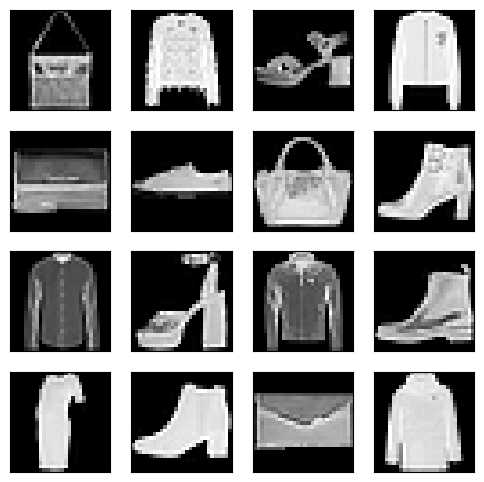

In [4]:
# To display the images, you need a function that plots them
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1, 2, 0).numpy(), cmap="gray")
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# You can update the num_rows and num_cols variables to change the number of images that are displayed
for data, label in training_loader:
    show_images(data, 4, 4)
    break

---
## Define the model
 
Now that you have imported and reviewed the data, you need to build a linear model with a single dense layer that takes in a vector of length 784 (the number of input features) and returns another vector of length 10 (the number of output classes). Remember that you need to initialize weights and biases to get a first prediction and evaluation of the output that the MLP produces. A good starting point is to use a normal distribution for weights and zeros for biases.

In [5]:
# Specify how many classes to predict (this needs to match the labels)
in_features = 784
out_classes = 10

# Single-layer network; flatten is required because you are working with images, and each row should represent one data point.
mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(
        in_features, out_classes
    ),  # Use CrossEntropyLoss later with SoftMax built in, so no need to add here
)

# Initialize the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        nn.init.zeros_(m.bias)

mlp.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../common/images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To test your understanding of neural net architectures, run the following cell.</p>
    <br>
</div>

In [6]:
# Run this cell to display the question and check your answer
question_1

In [7]:
# Display the initial values of the w and b
weight, bias = list(mlp.parameters())

# Print weight and bias tensors
print("Weights:")
print(weight)
print("\nBiases:")
print(bias)

Weights:
Parameter containing:
tensor([[-8.0230e-03,  1.0492e-02,  2.5681e-02,  ...,  1.9502e-02,
         -1.2786e-02, -2.5231e-03],
        [-4.6568e-03, -5.5659e-03, -8.3754e-03,  ..., -5.5785e-04,
         -2.1754e-03, -7.2378e-03],
        [-4.8140e-03,  5.0513e-05,  8.2666e-03,  ..., -5.6571e-03,
          5.9721e-03,  5.3537e-03],
        ...,
        [ 2.9196e-03,  1.0826e-02,  1.3621e-02,  ..., -7.8880e-03,
          1.8409e-02,  7.9349e-03],
        [ 9.9070e-03, -1.6005e-03, -2.1816e-03,  ..., -5.4700e-03,
         -1.4414e-02, -7.3915e-03],
        [ 2.2625e-03,  5.8132e-03,  9.5944e-04,  ...,  6.5023e-03,
         -2.6057e-03, -2.1527e-03]], requires_grad=True)

Biases:
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


---
Now that everything is set up, test how well the untrained network performs when making predictions on the test dataset.

In [8]:
# Look at 10 predictions in the first batch of data in the training loader
for i, (data, label) in enumerate(training_loader):
    pred = mlp(data)
    print("Predictions:")
    print(torch.softmax(pred, dim=1).argmax(axis=1)[:10])
    print("\nTrue labels:")
    print(label[:10])
    break

Predictions:
tensor([0, 9, 4, 4, 0, 4, 9, 4, 4, 4])

True labels:
tensor([2, 6, 5, 0, 2, 2, 7, 4, 6, 9])


As you can see, the model appears to be randomly guessing. Think about why the predictions are random.

You might recall that you generated a normal distribution for weights and set the biases to zero. Those values have not been updated because you have not performed any training yet. While the code cell above doesn't create good predictions, you can use it to verify that the general architecture of the model works.

Now you are ready to train the neural network.

---
## Train the neural network

The training loop is similar to what you built in the previous lab. The main difference is that you will use `torch.optim` to complete the optimization algorithm. You will learn about different optimizers later in the course. For now, use the well-known stochastic gradient descent (SGD).

In [17]:
# Determine if a GPU resource is available; otherwise, use CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"

# This is a multiclass classification, so you want to use nn.CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()
device

'cpu'

First, you need to write a function to train the neural network. When you imported the data, you broke it into batches, so you need to include a loop for the training batches.

In [10]:
# Function to train the network

def train_net(net, train_loader, val_loader, num_epochs=1, learning_rate=0.1):
    # Define the optimizer, SGD with learning rate
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

    # Initialize loss and accuracy lists
    train_losses, train_accs, val_accs = [], [], []

    for epoch in range(num_epochs):
        net = net.to(device)

        # Initialize loss and accuracy values
        train_loss, val_loss, train_acc, val_acc = 0.0, 0.0, 0.0, 0.0

        # Training loop: (with autograd and trainer steps)
        # This loop trains the neural network (weights are updated)
        for i, (data, label) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()
            data = data.to(device)
            label = label.to(device)
            output = net(data)
            loss = criterion(output, label)  # Compute the total loss in the train batch
            loss.backward()
            train_acc += (output.argmax(axis=1) == label.float()).float().mean()
            train_loss += loss
            optimizer.step()

        # Validation loop:
        # This loop tests the trained network on the dation dataset. No weight updates here.
        for i, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)
            output = net(data)  # Compute the total loss in the validation batch
            val_acc += (output.argmax(axis=1) == label.float()).float().mean()
            val_loss += criterion(output, label)

        # Take averages
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())
        val_accs.append(val_acc.item())

        print(
            "Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f"
            % (
                epoch + 1,
                train_loss.detach().cpu().numpy(),
                train_acc.detach().cpu().numpy(),
                val_loss.detach().cpu().numpy(),
                val_acc.detach().cpu().numpy(),
            )
        )

    return train_losses, train_accs, val_accs

Now that you have created a training function, use it to train the model. 

In [ ]:
# Train the neural network
train_losses, train_accs, val_accs = train_net(
    mlp, training_loader, validation_loader, num_epochs=25, learning_rate=0.03
)

After training finishes, you can create plots of the training loss, training accuracy, and validation accuracy. This will help you determine how well your model is performing.

In [ ]:
# Define a function to plot the training losses
def plot_losses(train_losses, train_acc, val_acc):

    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss values")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(train_acc, "g", label="Train Accuracy")
    plt.plot(val_acc, "red", label="Validation Accuracy")
    plt.title("Accuracy values")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# Plot the training loss function and accuracy
plot_losses(train_losses, train_accs, val_accs)

As you look at the graphs, think about the following questions.
1. What do you notice about the training loss? 
1. Was 25 epochs enough? 
1. Why is the validation accuracy lower than the training accuracy? 
1. Is the accuracy high enough to consider this a good model?

What other questions do you have after reviewing the graphs?

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../common/images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To test your understanding of epochs and learning rate, run the following cell.</p>
    <br>
</div>

In [ ]:
# Run this cell to display the question and check your answer
question_2

---
## Add a dropout layer

In this final step, you will add a dropout layer to prevent overfitting. A dropout layer randomly drops a certain percentage or number of neurons in a given layer. You can specify how much to drop with `nn.Dropout`.

Add another layer and a dropout layer after it to see how that affects the loss and accuracy values.

In [ ]:
# Add a hidden layer and dropout layer in between
mlp_dropout = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 784),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, out_classes),
)

num_epochs = 25

# Train the model by using the newly defined neural network
train_losses, train_accs, val_accs = train_net(
    mlp_dropout,
    training_loader,
    validation_loader,
    num_epochs=num_epochs,
    learning_rate=0.01,
)

In [ ]:
# Plot the loss function and accuracy graphs
plot_losses(train_losses, train_accs, val_accs)

As you look at the graphs, think about the following questions.
1. How do they compare to your original model without the dropout layer?
1. Is the accuracy of the new model better?
1. How does this impact the number of epochs that you need?
1. Does changing any of the settings (such as the dropout, learning rate, or epochs) improve the accuracy?

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../common/images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To test your understanding of dropout layers, run the following cell.</p>
    <br>
</div>

In [ ]:
# Run this cell to display the question and check your answer
question_3

----
## Conclusion

In this notebook, you learned how to build a more advanced neural network. Topics such as dense networks and dropout layers should start to make more sense as you build more understanding about building models.

--- 
## Next lab
In the next lab, you will learn how to build an end-to-end neural network.